## TensorFlow 2.x

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data[['normalizedAmount', 'Amount']].head()

,normalizedAmount,Amount
0,0.244964,149.62
1,-0.342475,2.69
2,1.160686,378.66
3,0.140534,123.50
4,-0.073403,69.99


In [4]:
# Examine the Class values
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
X = data.drop(['Time', 'Amount', 'Class'], axis=1)
y = data['Class']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)

(199364, 29)
(85443, 29)


## Undersampling

In [7]:
# Undersample data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
temp = X_train.sample(frac=1)
temp['Class'] = y_train
class1 = temp.loc[temp['Class'] == 1]
class0 = temp.loc[temp['Class'] == 0][:class1.shape[0]]

# udf = undersample dataframe
udf = pd.concat([class1, class0]).sample(frac=1)
print(udf.shape)
print(udf['Class'].value_counts())

(686, 30)
1    343
0    343
Name: Class, dtype: int64


In [8]:
# Create the model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
uX = udf.drop(['Class'], axis=1)
uy = udf['Class']

In [10]:
uX_train, uX_test, uy_train, uy_test = train_test_split(uX, uy, test_size = 0.3)
print(uX_train.shape)
print(uX_test.shape)

(480, 29)
(206, 29)


In [11]:
inputs = uX_train.shape[1]
layers = inputs * 2

# umodel = model for undersampled data
umodel = Sequential()
umodel.add(Dense(layers, kernel_initializer='uniform', activation='relu', input_dim=inputs))
umodel.add(Dense(inputs, activation='relu'))
umodel.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.01)
umodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(umodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 58)                1740      
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1711      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Create earlystopping callback
earlystopping = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 5,
                             verbose = 1,
                             restore_best_weights = True)

callbacks = [earlystopping]
uhistory = umodel.fit(uX_train,
                     uy_train,
                     epochs = 25,
                     verbose = 1,
                     validation_data = (uX_test, uy_test),
                     callbacks = callbacks)

Train on 480 samples, validate on 206 samples
Epoch 1/25
480/480 [==============================] - 0s 342us/sample - loss: 0.3303 - accuracy: 0.8396 - val_loss: 0.1250 - val_accuracy: 0.9563
Epoch 2/25
480/480 [==============================] - 0s 61us/sample - loss: 0.1379 - accuracy: 0.9417 - val_loss: 0.1208 - val_accuracy: 0.9563
Epoch 3/25
480/480 [==============================] - 0s 56us/sample - loss: 0.1136 - accuracy: 0.9417 - val_loss: 0.1226 - val_accuracy: 0.9660
Epoch 4/25
480/480 [==============================] - 0s 51us/sample - loss: 0.0937 - accuracy: 0.9563 - val_loss: 0.1461 - val_accuracy: 0.9563
Epoch 5/25
480/480 [==============================] - 0s 50us/sample - loss: 0.0808 - accuracy: 0.9625 - val_loss: 0.1255 - val_accuracy: 0.9612
Epoch 6/25
480/480 [==============================] - 0s 51us/sample - loss: 0.0615 - accuracy: 0.9688 - val_loss: 0.1456 - val_accuracy: 0.9515
Epoch 7/25
480/480 [==============================] - 0s 65us/sample - loss: 0.0526

In [13]:
uscore = umodel.evaluate(uX_test, uy_test)
print('Test loss: ', uscore[0])
print('Test accuracy: ', uscore[1])

206/206 [==============================] - 0s 34us/sample - loss: 0.1208 - accuracy: 0.9563
Test loss:  0.12084446876373106
Test accuracy:  0.9563107


In [14]:
# Get predictions
upredictions = umodel.predict(uX_test).round()

[[101   3]
 [  6  96]]

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       104
           1       0.97      0.94      0.96       102

    accuracy                           0.96       206
   macro avg       0.96      0.96      0.96       206
weighted avg       0.96      0.96      0.96       206



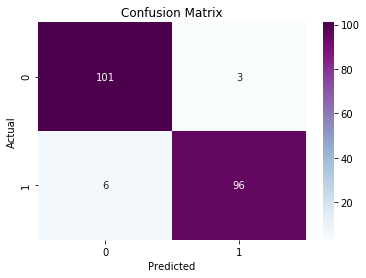

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(uy_test, upredictions)
print(cm)
print()
cr = classification_report(uy_test, upredictions)
print(cr)
sn.heatmap(cm, annot=True, cmap='BuPu', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Oversampling

In [16]:
from imblearn.over_sampling import SMOTE

# o = oversample
oX = temp.drop(['Class'], axis=1)
oy = temp['Class']
oversample = SMOTE()
oX, oy = oversample.fit_resample(oX, oy)
print(oy.value_counts())

Using TensorFlow backend.


1    199021
0    199021
Name: Class, dtype: int64


In [17]:
oX_train, oX_test, oy_train, oy_test = train_test_split(oX, oy, test_size = 0.3)
print(oX_train.shape)
print(oX_test.shape)

(278629, 29)
(119413, 29)


In [18]:
# Create the model
inputs = oX_train.shape[1]
layers = inputs * 2

omodel = Sequential()
omodel.add(Dense(layers, kernel_initializer='uniform', activation='relu', input_dim=inputs))
omodel.add(Dense(inputs, activation='relu'))
omodel.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.01)
omodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(omodel.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 58)                1740      
_________________________________________________________________
dense_4 (Dense)              (None, 29)                1711      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 30        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
ohistory = omodel.fit(oX_train,
                     oy_train,
                     epochs=25,
                     verbose=1,
                     validation_data=(oX_test, oy_test),
                     callbacks=callbacks)

Train on 278629 samples, validate on 119413 samples
Epoch 1/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0109 - val_accuracy: 0.9973
Epoch 2/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0061 - val_accuracy: 0.9988
Epoch 3/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.0075 - val_accuracy: 0.9985
Epoch 4/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0047 - val_accuracy: 0.9993
Epoch 5/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0051 - val_accuracy: 0.9993
Epoch 6/25
278629/278629 [==============================] - 16s 56us/sample - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0095 - val_accuracy: 0.9984
Epoch 7/25
278629/278629 [==========

In [20]:
oscore = omodel.evaluate(oX_test, oy_test)
print('Oversampled test loss: ', oscore[1])
print('Oversampled test accuracy: ', oscore[0])
print('Compared with')
print('Undersampled test loss: ', uscore[1])
print('Undersampled test accuracy: ', uscore[0])

119413/119413 [==============================] - 3s 27us/sample - loss: 0.0041 - accuracy: 0.9995
Oversampled test loss:  0.99953103
Oversampled test accuracy:  0.004088886245122444
Compared with
Undersampled test loss:  0.9563107
Undersampled test accuracy:  0.12084446876373106


In [21]:
# Get predictions
opredictions = omodel.predict(oX_test).round()

In [22]:
# Compare confusion matrix and classification reports
ocm = confusion_matrix(oy_test, opredictions)
ocr = classification_report(oy_test, opredictions)
print('Undersampled Confusion Matrix')
print(cm)
print('Oversampled Confusion Matrix')
print(ocm)
print()
print('Undersampled Classification Report')
print(cr)
print('Oversampled Classification Report')
print(ocr)

Undersampled Confusion Matrix
[[101   3]
 [  6  96]]
Oversampled Confusion Matrix
[[59680    56]
 [    0 59677]]

Undersampled Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       104
           1       0.97      0.94      0.96       102

    accuracy                           0.96       206
   macro avg       0.96      0.96      0.96       206
weighted avg       0.96      0.96      0.96       206

Oversampled Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59736
           1       1.00      1.00      1.00     59677

    accuracy                           1.00    119413
   macro avg       1.00      1.00      1.00    119413
weighted avg       1.00      1.00      1.00    119413

